# MA 592 Project

## Import Data


In [23]:
from scipy.io import mmread
# Read Count Matrix data and names

# counts_mat = mmread("./CD14_mtxs/CD14_counts.mtx").todense()
counts_mat = mmread("./dataset_norm/CD14_norm_counts.mtx").todense()
# with open("./CD14_mtxs/CD14_c_colnames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_c_colnames.txt", 'r') as f:
    counts_rownames = [x[:-1] for x in f.readlines()]
# with open("./CD14_mtxs/CD14_c_rownames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_c_rownames.txt", 'r') as f:
    counts_colnames = [x[:-1] for x in f.readlines()]

# Read Pertubation Matrix data and names

# pert_mat = mmread("./CD14_mtxs/CD14_perturbations.mtx").todense()
pert_mat = mmread("./dataset_norm/CD14_norm_p.mtx").todense()
# with open("./CD14_mtxs/CD14_p_colnames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_p_colnames.txt", 'r') as f:
    pert_rownames = [x[:-1] for x in f.readlines()]
# with open("./CD14_mtxs/CD14_p_rownames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_p_rownames.txt", 'r') as f:
    pert_colnames = [x[:-1] for x in f.readlines()]


## Conversion to Pandas Dataframe

In [24]:
import numpy as np
import pandas as pd

# Make Counts Dataframe
counts_df = pd.DataFrame(data=counts_mat.transpose(), columns=counts_colnames)
# Insert proteins by rowname as first column
counts_df.insert(loc=0, column="Cell", value=counts_rownames)

# Same process for perturbations
pert_df = pd.DataFrame(data=pert_mat.transpose(), columns=pert_colnames)
pert_df.insert(loc=0, column="Cell", value=pert_rownames)

In [3]:
counts_df["CDC42"].groupby(by=lambda x: counts_df["CDC42"][x] // 0.01).count()

0.0      1657
36.0        1
37.0        2
38.0        1
40.0        1
         ... 
340.0       1
342.0       1
352.0       1
353.0       1
374.0       1
Name: CDC42, Length: 283, dtype: int64

## Instrumental Variables

In [4]:
import matplotlib.pyplot as plt

def getFHat(x, n=None):
    if x.dtype == 'float':
        f = x.groupby(by=lambda i: x[i] // 1).count()
    else:
        f = x.value_counts().sort_index()
    if n is None:
        n = f.index.max()
    return f.reindex(range(n+1), fill_value=0).cumsum() / f.sum()

def getThreshold(fx0, fx1, d=0.25, n=None):
    if n is None:
        n = fx0.index.max()
    weights = (n-pd.Series(range(n+1)))/(n*(1+pd.Series(range(n+1)))**d) # Considering setting this to 1
    return (weights*(fx1-fx0)).argmax()

def IV(Z, X, Y, d=0.25):
    X0, X1 = X.loc[Z == 0], X.loc[Z == 1]
    Y0, Y1 = Y.loc[Z == 0], Y.loc[Z == 1]

    Nx = int(X.max())
    Ny = int(Y.max())
    FX0, FX1 = getFHat(X0, Nx), getFHat(X1, Nx)
    FY0, FY1 = getFHat(Y0, Ny), getFHat(Y1, Ny)
    alpha = getThreshold(FX0, FX1, d, Nx)
    beta = getThreshold(FY0, FY1, d, Ny)
#     alpha=beta=0.5

    A0, A1 = (X0 > alpha).astype(int), (X1 > alpha).astype(int)
    B0, B1 = (Y0 > beta).astype(int), (Y1 > beta).astype(int)

    Adiff, Bdiff = A0.mean()-A1.mean(), B0.mean()-B1.mean()
    LATE = Bdiff / Adiff
    return LATE, Adiff, Bdiff

### Import gene pairs for analysis

In [5]:
markers_df = pd.read_csv("KOvsControl_markers - high priority.csv")

Xmarkers = markers_df["compare"].str.extract('^([A-Z|\d]+)_').values[:,0]
Ymarkers = markers_df["gene"].to_list()
for Xmarker,Ymarker in zip(Xmarkers, Ymarkers):
    try:
        print(Xmarker, Ymarker, IV(pert_df[Xmarker], counts_df[Xmarker], counts_df[Ymarker]))
    except KeyError as e:
        print("Not Found:", e)

TRAF6 TRAF1 (-115.96647928378093, -0.0023064400724154, 0.2674697348770427)
TRAF6 CD83 (-60.84405579845924, -0.0023064400724154, 0.14033316846184496)
TRAF6 NFKBIA (-39.59379554445139, -0.0023064400724154, 0.091320716662745)
TRAF6 NFKB1 (-64.6579221320008, -0.0023064400724154, 0.14912962260436124)
TRAF6 CD44 (-58.04288986050384, -0.0023064400724154, 0.13387244709305957)
TRAF6 CD40 (-80.59816781178425, -0.0023064400724154, 0.18589484400436024)
TRAF6 CD300A (3.05330002082032, -0.0023064400724154, -0.007042253521126761)
TRAF6 TRAF3IP3 (16.194045388298974, -0.0023064400724154, -0.03735059521808656)
TRAF6 TRAPPC6A (2.195919217155944, -0.0023064400724154, -0.005064756078235523)
TRAF6 CD1D (19.408494690818234, -0.0023064400724154, -0.04476452990016471)
TRAF6 MAP3K1 (2.9808453050176964, -0.0023064400724154, -0.00687514106116412)
TRAF6 CD164 (3.9483656048303133, -0.0023064400724154, -0.009106668651527303)
TRAF6 CD82 (-48.50010410160315, -0.0023064400724154, 0.111862583616256)
TRAF6 MAP3K11 (21.06

# Bootstrap

0


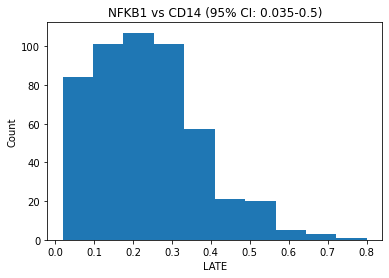

0


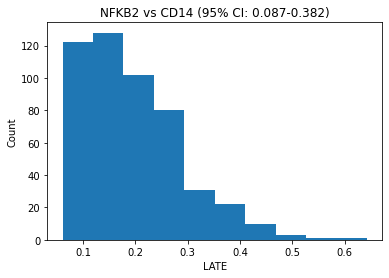

In [32]:
%matplotlib inline
def bootstrap(Z, X, Y, reps=500, prog = True):
    LATEs = []
    n = X.shape[0]
    for x in range(reps):
        if prog and x % 1000 == 0:
            print(x)
        indicies = np.random.randint(0, n, n)
        LATEs.append(IV(Z[indicies], X[indicies], Y[indicies]))
    return LATEs

def save_graph(ZX_name, Y_name, figure):
    figure.savefig("./figures/{} vs {}".format(ZX_name, Y_name), facecolor='white', transparent=False)

def find_CI(data, CI):
    return round(np.percentile(data, 100 - CI),3), round(np.percentile(data, CI),3)

def bootstrap_n_save(ZX_name, Y_name, CI = 95, print_below = True, save = True):
    if print_below:
        plt.ion()
    else:
        plt.ioff()
    
    # Get bootstrapped LATEs
    LATEs = bootstrap(pert_df[x[0]], counts_df[x[0]], counts_df[x[1]])
    # Get CI values
    lower_bound, upper_bound = find_CI(LATEs, CI)
    
    # Create graph
    fig, ax = plt.subplots()
    ax.hist(LATEs)
    ax.set_title("{} vs {} ({}% CI: {}-{})".format(ZX_name, Y_name, CI, lower_bound, upper_bound))
    ax.set_xlabel("LATE")
    ax.set_ylabel("Count")

    # Save figure if desired
    if save:
        save_graph(ZX_name, Y_name, fig)

    # Show figure in jupyter if desired
    if print_below:
        plt.show()
    else:
        plt.close()


pairs = [["NFKB1", "CD14"], ["NFKB2", "CD14"]]

for x in pairs:
    bootstrap_n_save(x[0], x[1])
